### Import Libraries
Import all the required libraries , used for this project

In [9]:
import numpy as  np
import matplotlib.pyplot as plt
import cv2
import sklearn as sk
import glob
import random as rd
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import moviepy
from moviepy.editor import VideoFileClip
import pickle

### Data Visualization

Load the data and visualise it.

Total No. of Images with Car :  8792
Total No. of Images without Car :  8968


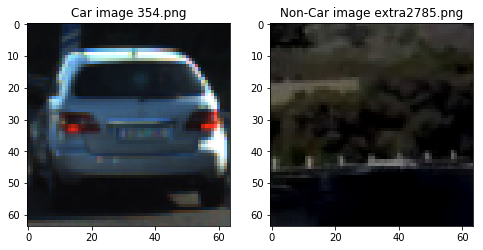

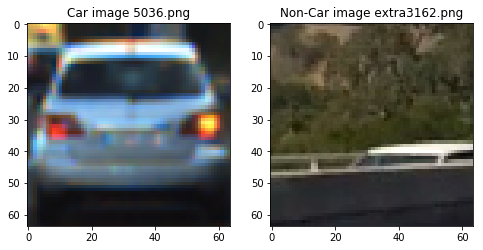

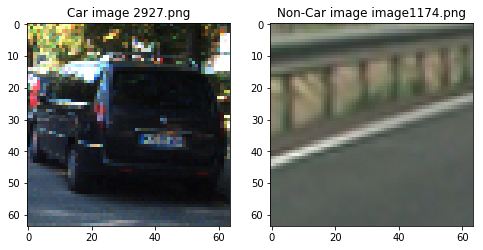

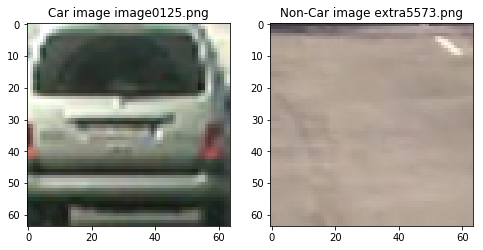

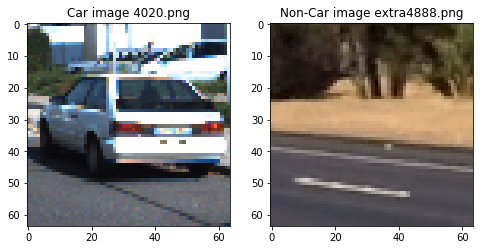

In [2]:
#get training data from various folders using glob

car_images = glob.glob("vehicles/*/*.png")
noncar_images = glob.glob("non-vehicles/*/*.png")

print ("Total No. of Images with Car : ", len(car_images))
print ("Total No. of Images without Car : ",len(noncar_images))

# pick 5 random images from both the set and visualise 

for i in range (0,5):
    
    car_random= rd.randint(0,len(car_images))
    noncar_random = rd.randint(0,len(noncar_images))
    figc , axisc = plt.subplots(1,2,figsize=(8,8))
    axisc[0].imshow(plt.imread(car_images[car_random]))
    axisc[0].set_title("Car image " + car_images[car_random].split("\\")[-1] )
    axisc[1].imshow(plt.imread(noncar_images[noncar_random]))
    axisc[1].set_title("Non-Car image " + noncar_images[noncar_random].split("\\")[-1] )

### Feature Extraction
Build code for extracting features from the data set

In [10]:
# functions for extracting features

# to get bin spatial features
# image passed would already be converted to required color space
def bin_spatial(img,size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img,size).ravel()
    # Return the feature vector
    return features

# to get color histogram features
# image passed would already be converted to required color space
def color_hist(img, nbins=32, bins_range=(0, 256),visualize=False):
    # Compute the histogram of the Passed channels separately
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if visualize == False :
        return hist_features
    
    else :
        
        # Generating bin centers
        edges = channel1_hist[1]
        bin_centers = (edges[1:] + edges[0:len(edges)-1])/2
               
        # Return the individual histograms, bin_centers and feature vector
        return hist_features,channel1_hist, channel2_hist, channel3_hist, bin_centers

# to get HOG features
# image passed would be single channle and already converte to required color space
def get_hog_features(img, orient, pix_per_cell, cell_per_block,visualize=False, feature_vector=True):
    
    if visualize == False:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',transform_sqrt=True, 
                       visualise=visualize, feature_vector=feature_vector)
        return features

    # Otherwise call with one output
    else:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=visualize, feature_vector=feature_vector)
        return features, hog_image

# function to combine all types of features and extract the required feature 
# It works for single image passed , have used various falgs to include and not include
# spatial and histogram features , HOG feature would be always fetched
def combine_features(img, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        bin_spatialFlag=True, color_histFlag=True):
    
        
    # apply color conversion if other than 'BGR'
    if color_space != 'BGR':
        color_change= eval("cv2.COLOR_BGR2" + color_space)
        changeImage = cv2.cvtColor(img,color_change)
          
    else:
        changeImage = np.copy(img)      

    # get spatial feature if asked for    
    if bin_spatialFlag == True:
            
        spatial_features = bin_spatial(changeImage, size=spatial_size)

    # get histogram feature if asked for    
    if color_histFlag == True:
            
        hist_features = color_hist(changeImage, nbins=hist_bins)
            
    # get HOG feature , run 3 times if all features are required by passing ALL
    # else only passed channel would be used for fetching HOG feature
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(changeImage.shape[2]):
            hog_features.append(get_hog_features(changeImage[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        visualize=False, feature_vector=True))
        hog_feature = np.ravel(hog_features)        
            
    else:
        hog_feature = get_hog_features(changeImage[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, visualize=False, feature_vector=True)
    
    # combine features based on the features extracted using flags
    if bin_spatialFlag == True and color_histFlag==True :
        feature=np.concatenate((hog_feature,spatial_features, hist_features))
        
    elif bin_spatialFlag==True :
        feature=np.concatenate((hog_feature,spatial_features))
            
    elif color_histFlag==True:
        feature=np.concatenate((hog_feature,hist_features))
            
    else:
        feature=hog_feature
    
    # Return final list of feature vectors
    return feature
    

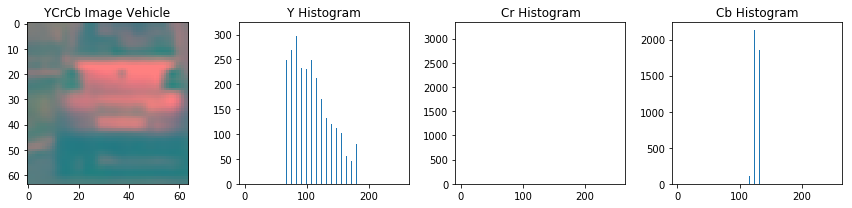

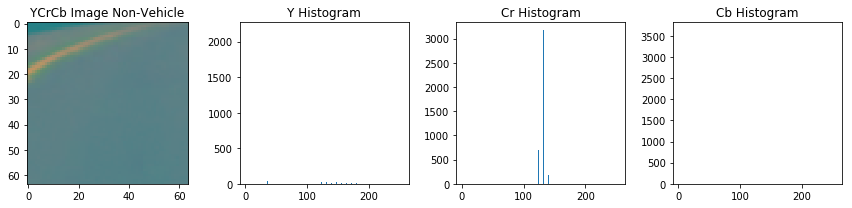

In [36]:
# Visualize the histogram feature extraction

vis_image = cv2.cvtColor(cv2.imread(car_images[100]),cv2.COLOR_BGR2YCrCb)

# get histogram feature
hist_features_v,channel1_hist_v, channel2_hist_v, channel3_hist_v, bin_centers_v=color_hist(vis_image,visualize=True)

fig,axis = plt.subplots(1,4,figsize=(12,3))
axis[0].imshow(vis_image)
axis[0].set_title('YCrCb Image Vehicle')
axis[1].bar(bin_centers_v,channel1_hist_v[0] )
axis[1].set_title('Y Histogram')
axis[2].bar(bin_centers_v,channel2_hist_v[0] )
axis[2].set_title('Cr Histogram')
axis[3].bar(bin_centers_v,channel3_hist_v[0] )
axis[3].set_title('Cb Histogram')
plt.tight_layout()

#visualize for Non-Vehicle Image
vis_noncarimage = cv2.cvtColor(cv2.imread(noncar_images[100]),cv2.COLOR_BGR2YCrCb)

# get histogram feature
hist_features_v,channel1_hist_v, channel2_hist_v, channel3_hist_v, bin_centers_v=color_hist(vis_noncarimage,visualize=True)

fig,axis = plt.subplots(1,4,figsize=(12,3))
axis[0].imshow(vis_noncarimage)
axis[0].set_title('YCrCb Image Non-Vehicle')
axis[1].bar(bin_centers_v,channel1_hist_v[0] )
axis[1].set_title('Y Histogram')
axis[2].bar(bin_centers_v,channel2_hist_v[0] )
axis[2].set_title('Cr Histogram')
axis[3].bar(bin_centers_v,channel3_hist_v[0] )
axis[3].set_title('Cb Histogram')
plt.tight_layout()


Vehicle Image Spatial Feature Shape :  (3072,)
Non-Vehicle Image Spatial Feature Shape :  (3072,)


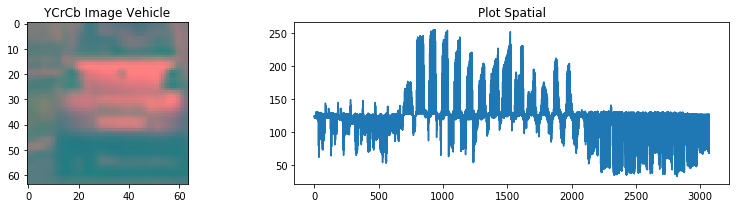

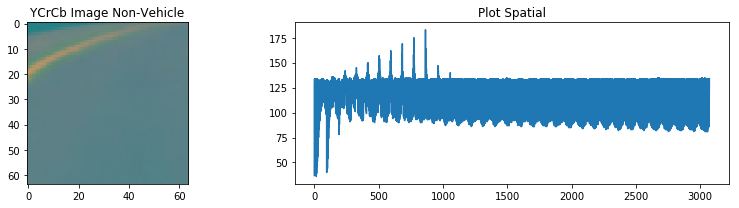

In [37]:
# Visualize the Spatial feature extraction

vis_image = cv2.cvtColor(cv2.imread(car_images[100]),cv2.COLOR_BGR2YCrCb)

# get spatial feature
feature=bin_spatial(vis_image)

print ( "Vehicle Image Spatial Feature Shape : " ,feature.shape)

fig,axis = plt.subplots(1,2,figsize=(12,3))
axis[0].imshow(vis_image)
axis[0].set_title('YCrCb Image Vehicle')
axis[1].plot(feature )
axis[1].set_title('Plot Spatial')

plt.tight_layout()

#visualize for Non-Vehicle Image
vis_image = cv2.cvtColor(cv2.imread(noncar_images[100]),cv2.COLOR_BGR2YCrCb)

# get spatial feature
feature=bin_spatial(vis_image)

print ( "Non-Vehicle Image Spatial Feature Shape : " ,feature.shape)

fig,axis = plt.subplots(1,2,figsize=(12,3))
axis[0].imshow(vis_image)
axis[0].set_title('YCrCb Image Non-Vehicle')
axis[1].plot(feature )
axis[1].set_title('Plot Spatial')

plt.tight_layout()

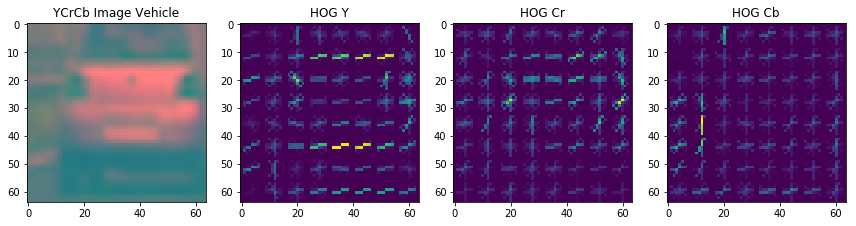

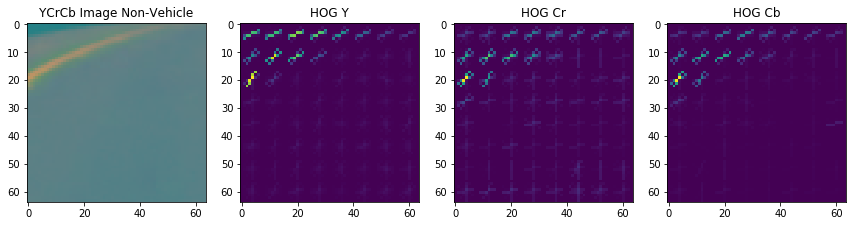

In [38]:
# Visualize HOG feature extraction

vis_image = cv2.cvtColor(cv2.imread(car_images[100]),cv2.COLOR_BGR2YCrCb)

# get HOG feature for all channels
feature_ch1,img_ch1=get_hog_features(vis_image[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)
feature_ch2,img_ch2=get_hog_features(vis_image[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)
feature_ch3,img_ch3=get_hog_features(vis_image[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)

fig,axis = plt.subplots(1,4,figsize=(12,3))
axis[0].imshow(vis_image)
axis[0].set_title('YCrCb Image Vehicle')
axis[1].imshow(img_ch1 )
axis[1].set_title('HOG Y')
axis[2].imshow(img_ch2 )
axis[2].set_title('HOG Cr')
axis[3].imshow(img_ch3 )
axis[3].set_title('HOG Cb')

plt.tight_layout()

#visualize for Non-Vehicle Image
vis_image = cv2.cvtColor(cv2.imread(noncar_images[100]),cv2.COLOR_BGR2YCrCb)

# get HOG feature for all channels
feature_ch1,img_ch1=get_hog_features(vis_image[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)
feature_ch2,img_ch2=get_hog_features(vis_image[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)
feature_ch3,img_ch3=get_hog_features(vis_image[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2,visualize=True)

fig,axis = plt.subplots(1,4,figsize=(12,3))
axis[0].imshow(vis_image)
axis[0].set_title('YCrCb Image Non-Vehicle')
axis[1].imshow(img_ch1 )
axis[1].set_title('HOG Y')
axis[2].imshow(img_ch2 )
axis[2].set_title('HOG Cr')
axis[3].imshow(img_ch3 )
axis[3].set_title('HOG Cb')

plt.tight_layout()

### Train Classifier
Extarct features for all data set and train using LinearSVC classifier

In [11]:
#Parameter Declaration for Classification
color_space = 'YCrCb' 
spatial_size = (32, 32) # for Spatial Feature
hist_bins = 32    # for Histogram Feature
orient = 9  # for HOG feature
pix_per_cell = 8 # for HOG feature
cell_per_block = 2 # for HOG feature
hog_channel = "ALL" # for HOG feature , in case of 'ALL' , all 3 channels would be considered
spatial_feature = True # Flag for Spatial features to turn on or off
hist_feature = True # Flag for Histogram features to turn on or off


In [40]:
# extract features from all the images in data set both vehicle and non-vehicle
print ("Initiate Feature Extraction Process")
car_features=[]
noncar_features=[]

#iterate over vehicle images list and append features to car_feature list
for carimage in car_images:
    
    #read images using cv2
    img = cv2.imread(carimage)
    car_feature = combine_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feature, color_histFlag=hist_feature)
    car_features.append(car_feature)

print ("Car Feature Shape :",car_features[0].shape)    
print ("Total No. of Images Processed :" , len(car_features))

#iterate over non-vehicle images list and append features to noncar_feature list
for noncarimage in noncar_images:
    
    #read image using cv2
    img = cv2.imread(noncarimage)
    noncar_feature = combine_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feature, color_histFlag=hist_feature)
    noncar_features.append(noncar_feature)
    
print ("Non-Car Feature Shape :",noncar_features[0].shape) 
print ("Total No. of Images Processed :" , len(noncar_features))

Initiate Feature Extraction Process
Car Feature Shape : (8460,)
Total No. of Images Processed : 8792
Non-Car Feature Shape : (8460,)
Total No. of Images Processed : 8968


In [41]:
# split data and apply pre-processing 
# get Xtrain , YTrain and XTest and YTest from the features collected .


# Create an array stack of feature vectors of both car and non-car
X = np.vstack((car_features, noncar_features)).astype(np.float64)

print ("Total Data (car & non-car) : ", len(X))

# Define the labels vector for car and non-car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print ("Total Ground Truth Data (car & non-car) : ", len(y))

#shuffle data 
X,y = shuffle(X,y)

# Split up data into randomized training and test sets with 80:20 ratio
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print ("Total Train Data (car & non-car) : ", len(X_train))
print ("Total Ground Truth Data (car & non-car) : ", len(y_train))

print ("Total Test Data (car & non-car) : ", len(X_test))
print ("Total Ground Test Data (car & non-car) : ", len(y_test))

Total Data (car & non-car) :  17760
Total Ground Truth Data (car & non-car) :  17760
Total Train Data (car & non-car) :  14208
Total Ground Truth Data (car & non-car) :  14208
Total Test Data (car & non-car) :  3552
Total Ground Test Data (car & non-car) :  3552


In [43]:
# train the data with Classifer

# Fit a per-column scaler for normalization
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test as pre-processing set
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using: ',color_space ,' color space ',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block' , ' , Spatial Feature',spatial_feature,' ,Histogram Feature', hist_feature)
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the Linear SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC with Test Data
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using:  YCrCb  color space  9 orientations 8 pixels per cell and 2 cells per block  , Spatial Feature True  ,Histogram Feature True
Feature vector length: 8460
35.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


In [44]:
# save the model so that it can be used later while running the pipeline
model_saver = {}
model_saver["classifier"] = svc
model_saver["data_scaler"]= X_scaler


pickle.dump( model_saver, open( "model_saver_YCrCb.p", "wb" ) )
print ("Model saved to file model_saver_YCrCb.p")

Model saved to file model_saver_YCrCb.p


### Apply Sliding window
Use sliding window to fetch images which can be send to classifier for prediction and boxes can be drawn if car is detected.

In [12]:
# functions for sliding windows
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
  
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Resize , extract feature , predict classifier , draw box
Once windows are found , fetch the picture , resize to 64x64 as we have done training on 64x64 size images , once resized , extract feature from the image and send it to the classifer for prediction . If prediction is 1 i.e vehicle found , draw a box .

In [13]:
def search_cars(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, visualise=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        resize_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using combine_features()
        features = combine_features(resize_img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feat, color_histFlag=hist_feat)
        
        #5) Scale extracted features to be fed to classifier
        scaled_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(scaled_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


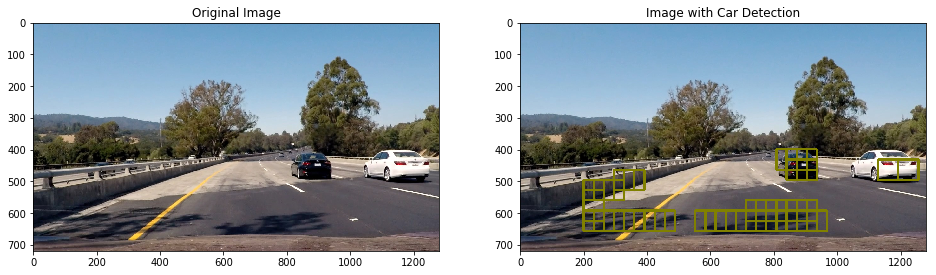

In [58]:
# test on images
image = cv2.imread('test_images/test4.jpg')
draw_image = np.copy(image)
y_start_stop= [400,680]

windows = slide_window(image, x_start_stop=[200, image.shape[1]], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_cars(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 128, 128), thick=6)                    

final_image = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)


fig, axis = plt.subplots(1,2,figsize=(16,16))
axis[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
axis[0].set_title("Original Image")
axis[1].imshow(final_image)
axis[1].set_title("Image with Car Detection")



#### Apply Heat Map to combine various bounding boxes and reduce false positive
Use heat map to combine various boxes detected to single box and also separate false positive , as seen in above visualisation

In [14]:

#function to get heat map
def get_heatMap (heatmap, boundingBoxes):
    # iterate through the bounding boxes
    for box in boundingBoxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # return the updated heat map
    return heatmap

#function to apply threshold on heatMap
def define_threshold_heatMap(heatmap,threshold=2):
    #set zero , were values less than threshold
    heatmap[heatmap<=threshold]=0
    # return updated heatmap
    return heatmap

#function which gets heapmap and apply threshhold , draw boxes 
def apply_heatMap(img,boundingBoxes,threshold,visualise=False):
    # get an array similar to image with zero's , use only single channel
    heatmap = np.zeros_like (img[:,:,0],np.float)
    
    #get heat map for the bounding boxes
    heatmap_ret = get_heatMap(heatmap,boundingBoxes)
    
    #apply threshold to heatmap returned from above function
    heatmap_thresh = define_threshold_heatMap(heatmap_ret,threshold)
    
    #apply numpy.clip so that all values are with in range of 0-255
    heatmap_res= np.clip(heatmap_thresh, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_res)
        
    result= draw_labeled_bboxes(img, labels)
    
    if visualise == True :
        
        return result,heatmap_res
    
    else:
        
        return result

# draw final boxes from heat map
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img    

#function which gets heapmap and apply threshhold , draw boxes 
#this alos implements averaging of past frames bounding boxes detected , used in pipeline
def apply_avg_heatMap(img,avgboundingBoxes,threshold,visualise=False):
    
    #combine all retangle values
    boundingBoxes=[]
    
    for bb_outer in avgboundingBoxes:
        for bb in bb_outer:
            boundingBoxes.append(bb)
        
    # get an array similar to image with zero's , use only single channel
    heatmap = np.zeros_like (img[:,:,0],np.float)
    
    #get heat map for the bounding boxes
    heatmap_ret = get_heatMap(heatmap,boundingBoxes)
    
    #apply threshold to heatmap returned from above function
    heatmap_thresh = define_threshold_heatMap(heatmap_ret,threshold)
    
    #apply numpy.clip so that all values are with in range of 0-255
    heatmap_res= np.clip(heatmap_thresh, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_res)
        
    result= draw_labeled_bboxes(img, labels)
    
    if visualise == True :
        
        return result,heatmap_res
    
    else:
        
        return result


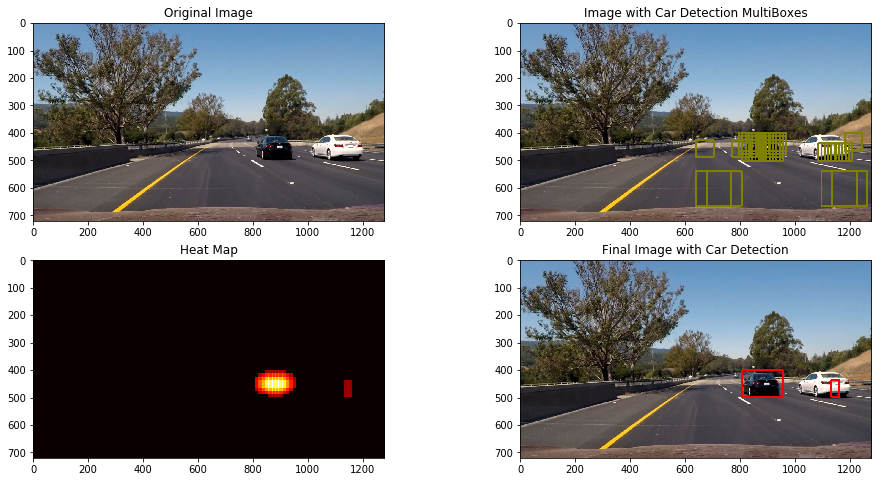

In [72]:
#visualise heat map and threshold

image = cv2.imread('test_images/test6.jpg')
draw_image = np.copy(image)
y_start_stop1= [400,500]
y_start_stop2= [500,600]
y_start_stop3= [500,680]
threshold=4
x_start_stop= [(draw_image.shape[1]//2), draw_image.shape[1]]

slide1 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop1, 
                    xy_window=(64,64), xy_overlap=(0.80, 0.80))
slide2 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop2, 
                    xy_window=(96,96), xy_overlap=(0.80, 0.80))
slide3 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop3, 
                    xy_window=(128,128), xy_overlap=(0.70, 0.70))



windows = slide1 + slide2 +  slide3 

hot_windows = search_cars(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 128, 128), thick=6)                    

withoutHeatMap_image = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)

final_image,heat_map_img = apply_heatMap (draw_image,hot_windows,threshold,visualise=True)

fig, axis = plt.subplots(2,2,figsize=(16,8))
axis[0][0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
axis[0][0].set_title("Original Image")
axis[0][1].imshow(withoutHeatMap_image)
axis[0][1].set_title("Image with Car Detection MultiBoxes")

axis[1][0].imshow(heat_map_img,cmap='hot')
axis[1][0].set_title("Heat Map")
axis[1][1].imshow(cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
axis[1][1].set_title("Final Image with Car Detection")

### Video Pipeline
Generate pipeline for Video , which can be used for detecting objects in videos.
I am using only right side of the widow for searching due to low processing power , also processing only 1 frame out of every 5 frames. for getting continutity have added code for averaging the bounding boxes added in past frames so as to reduce wobbling and missing frames , this also help reduce false positive too.

In [15]:

def pipeline(img):
    # declare global variables used in pipeline 
    global load_model # flag to tell if model is to be loaded or not 
    global model_data_v #to store required parameters for model
    global windows # to store searchable windows 
    global prev_windows # to store previous frame bounding boxes
    global frameNo , threshold 
    global ret_window
    
    #convert image to BGR as video will pass image in RGB and 
    #all functions are used with BGR conversion
    imgBGR = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    #make a copy of image to be processed on 
    draw_image = np.copy(imgBGR)
    
    #define sliding window parameters
    # have used different y co-ordinate for differnt window and size
    y_start_stop1= [400,500]
    y_start_stop2= [500,600]
    y_start_stop3= [500,680]
   
    # have used right half of the image for searching as have limited processing power
    # also to reduce video processing time
    x_start_stop= [(img.shape[1]//2), img.shape[1]]
   
   
    #check if model is already loaded or not 
    #in case not loaded , load the model , 
    #define windows to be searched once , so that repeated processing can be saved
    
    if load_model== True :

        model_data_v= pickle.load(open("model_saver_YCrCb.p","rb"))
        
        
        slide1 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop1, 
                    xy_window=(64,64), xy_overlap=(0.80, 0.80))
        slide2 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop2, 
                    xy_window=(96,96), xy_overlap=(0.80, 0.80))
        slide3 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop3, 
                    xy_window=(128,128), xy_overlap=(0.70, 0.70))
        #combine differnt windows to single 
        windows = slide1 + slide2 +  slide3 
        
        print ("No of Windows ", len(windows))
        load_model =False
        
        #find car on the images initially
        ret_window = search_cars(draw_image, windows, model_data_v["classifier"], model_data_v["data_scaler"], 
                                 color_space=color_space, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feature, 
                       hist_feat=hist_feature)
    
    
    # generate random number for processing random frame
    randomframe =  rd.randint(0,5)
    
    #check if number generated matches frame number then process the frame 
    #else don't process the frame and use old values
    if frameNo == randomframe :
        
        #process the frame
        ret_window = search_cars(draw_image, windows, model_data_v["classifier"], model_data_v["data_scaler"], 
                                 color_space=color_space, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feature, 
                       hist_feat=hist_feature)
        
        #once processed , add new boxdetails to previous list 
        prev_windows.append(ret_window)
    
    # if len of previous windows is more than 5 then pop out the first bounding boxes details
    if len(prev_windows) > 5 :
             prev_windows.pop(0)
      #13 - 3 video      
    
    # if 5 frames have passed then reset the frame number back to zero
    # else increment by 1
    if frameNo == 5:
         frameNo=0
    else :
         frameNo+=1
    
    # set threshold parameter for heat map
    threshold = 11
    
    # get the final image 
    finalImage = apply_avg_heatMap (draw_image,prev_windows,threshold,visualise=False)

    #code to append aditional image on video whihc shows actual image 
    imshape=finalImage.shape
    overlay_col_size = int(imshape[1]/3)
    overlay_row_size = int(imshape[0]/3)
    heatmap_final = draw_boxes(np.copy(draw_image), ret_window, color=(0, 0, 128), thick=6) 
    img_heatmap_resized = cv2.resize(heatmap_final, (overlay_col_size, overlay_row_size ))
    finalImage[:overlay_row_size , :overlay_col_size ] = img_heatmap_resized
    
    #convert back to RGB
    result = cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB)
    
    return result

In [ ]:
# run this code on the input video

#set default for global variables
load_model =True
windows= None
prev_windows= []
frameNo=0
model_data_v =None
ret_window=None
# set output video file name
output = 'project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4")
clipProcessed = clip2.fl_image(pipeline) 
%time clipProcessed.write_videofile(output, audio=False)
clipProcessed.reader.close()
clipProcessed.audio.reader.close_proc()

No of Windows  253
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [06:13<01:30,  3.42it/s]